###Импорт библиотек, загрузка датасета, установка

In [ ]:
import glob
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "russian_literature" -d ./dataset

--2024-06-06 12:11:28--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  11.0MB/s    in 1.9s    

2024-06-06 12:11:31 (11.0 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publi

In [ ]:
!pip install razdel
from razdel import tokenize

In [ ]:
# Загрузка предобученных эмбеддингов Navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

--2024-06-06 12:11:54--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.2s    

2024-06-06 12:11:58 (15.9 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



###Подготовка датасета

In [ ]:
# Список писателей
CLASS_LIST = ["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Pushkin"]

In [ ]:
# Чтение и токенизация с помощью Razdel
all_texts = {}
tokenized_texts = {}
for author in CLASS_LIST:
    all_texts[author] = ''
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) + glob.glob('./dataset/poems/{}/*.txt'.format(author)):
        with open(f'{path}', 'r', errors='ignore') as f:
            text = f.read()
        all_texts[author] += ' ' + text.replace('\n', ' ')
    tokenized_texts[author] = [token.text for token in tokenize(all_texts[author])]

In [ ]:
# Создание индекса для слов
embedding_dim = 300
max_words = 10000
all_tokens = [token for tokens in tokenized_texts.values() for token in tokens]
word_counts = Counter(all_tokens)
word_index = {word: i+1 for i, (word, count) in enumerate(word_counts.most_common(max_words))}

In [ ]:
def texts_to_sequences(tokenized_texts, word_index):
    return [[word_index.get(token, 0) for token in tokens] for tokens in tokenized_texts]

seq_train = [texts_to_sequences([tokenized_texts[author]], word_index)[0] for author in CLASS_LIST]
seq_train_balance = [seq_train[cls][:40000] for cls in range(len(CLASS_LIST))]

In [ ]:
WIN_SIZE = 1000
WIN_STEP = 100

def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(seq_list, test_split, class_list, win_size, step):
    x_train, y_train, x_test, y_test = [], [], [], []
    for class_item in class_list:
        cls = class_list.index(class_item)
        gate_split = int(len(seq_list[cls]) * (1-test_split))
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)
        x_train += vectors_train
        x_test += vectors_test
        y_train += [utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [utils.to_categorical(cls, len(class_list))] * len(vectors_test)
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.2, CLASS_LIST, WIN_SIZE, WIN_STEP)

val_split = int(len(x_train) * 0.1)
x_val = x_train[:val_split]
y_val = y_train[:val_split]
x_train = x_train[val_split:]
y_train = y_train[val_split:]

###Создание и компиляция модели обучения

In [ ]:
# Создание модели
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))

In [ ]:
# Создание embedding_matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = navec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Установка колбэка для сохранения лучших весов модели
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Обучение модели
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), callbacks=[checkpoint])

# Загрузка лучших весов модели
model.load_weights('best_model.h5')

Epoch 1/50
22/22 [==============================] - 10s 49ms/step - loss: 2.1735 - accuracy: 0.2836 - val_loss: 1.1548 - val_accuracy: 0.4452
Epoch 2/50
 4/22 [====>.........................] - ETA: 0s - loss: 0.5997 - accuracy: 0.7852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 20ms/step - loss: 0.3716 - accuracy: 0.8643 - val_loss: 1.0654 - val_accuracy: 0.2774
Epoch 3/50
22/22 [==============================] - 1s 24ms/step - loss: 0.1140 - accuracy: 0.9643 - val_loss: 2.3542 - val_accuracy: 0.0000e+00
Epoch 4/50
22/22 [==============================] - 0s 21ms/step - loss: 0.0615 - accuracy: 0.9821 - val_loss: 3.7318 - val_accuracy: 0.0000e+00
Epoch 5/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 4.3468 - val_accuracy: 0.0000e+00
Epoch 6/50
22/22 [==============================] - 0s 19ms/step - loss: 0.0260 - accuracy: 0.9943 - val_loss: 4.8922 - val_accuracy: 0.0000e+00
Epoch 7/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0213 - accuracy: 0.9964 - val_loss: 5.3161 - val_accuracy: 0.0000e+00
Epoch 8/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0241 - accuracy: 0.9943 - val_loss: 5.1575 - val_accuracy: 0.0000e+00


###Итоги

In [ ]:
# Визуализация процесса обучения
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], label='Точность на обучающей выборке')
    ax1.plot(history.history['val_accuracy'], label='Точность на валидационной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'], label='Ошибка на валидационной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Визуализация матрицы ошибок
def show_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize='true')
    cm = np.around(cm, 3)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

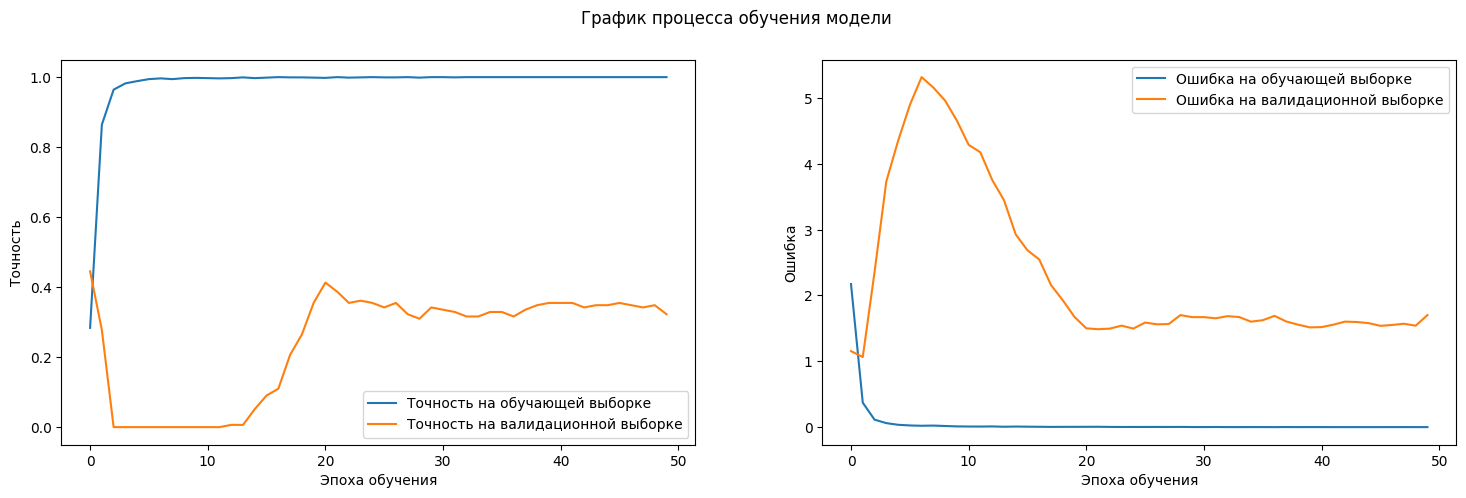

In [ ]:
# Визуализация процесса обучения
show_plot(history)

12/12 [==============================] - 0s 4ms/step


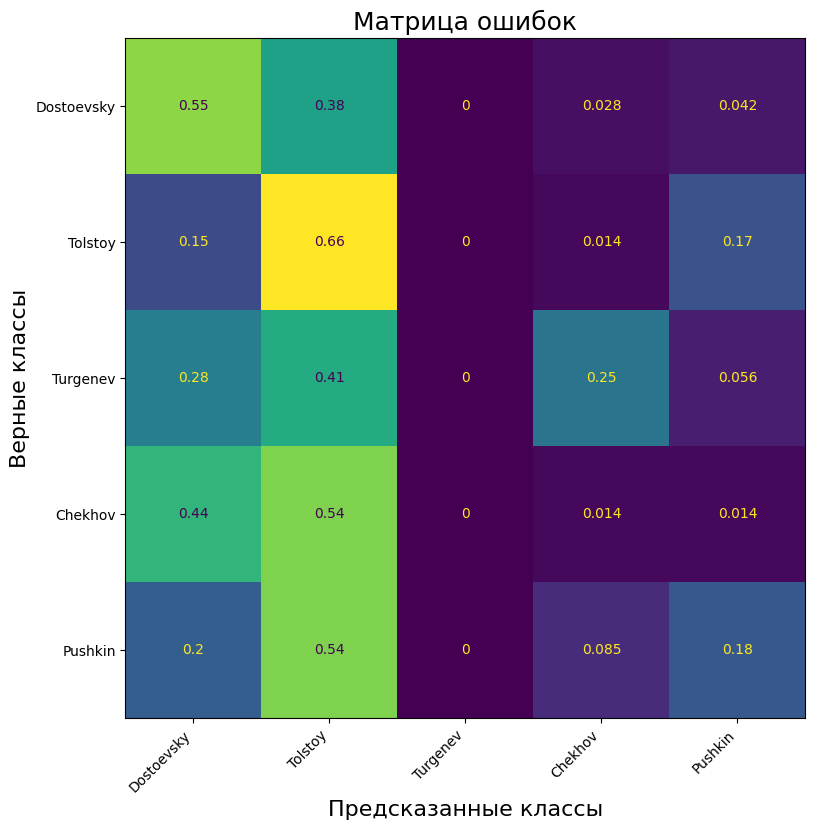


Средняя точность распознавания:  28%


In [ ]:
# Предсказания на тестовой выборке
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)